In [730]:
import os
import numpy as np
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy.signal import detrend
from sklearn.cluster import KMeans

In [731]:
#Setup Database
load_dotenv()
uri = os.environ['DB_URI']
client = MongoClient(uri)
db = client["rosen"]
collection = db["big_data_2"]

In [885]:
# for no only use region "Europe"
# TODO use other regions
documents = collection.find({"configuration": "Europe"}, {"_id": 1, "instrument": 1, "configuration": 1, "wall_thickness": 1, "magnetization": 1, "timestamp": 1})
files = pd.DataFrame(list(documents)[30:40])

In [886]:
# documents 19 looks good
#t = pd.DataFrame(documents[24])
#t.dropna(inplace=True)
#detrend(data=t["magnetization"], overwrite_data=True, type="linear")
#t.plot(kind="line", x="timestamp", y="magnetization")
def zscore_create_outliers_mask(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)  # Berechne den absoluten Z-Score für jeden Datenpunkt
    return z_scores < threshold  # True für Datenpunkte innerhalb des Schwellenwerts, False für Ausreißer

def iqr_create_outliers_mask(data, k=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data >= lower_bound) & (data <= upper_bound)

def std_create_outliers_mask(data, threshold = 1.5):
    mean = np.mean(data)
    std_dev = np.std(data)
    distance_from_mean = np.abs(data - mean) / std_dev
    mask = distance_from_mean < threshold
    return mask

In [887]:
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

def prepare_data(row):
    mask = ~np.isnan(row['magnetization'])
    clean_wall_thickness = np.array(row['wall_thickness'])[mask]
    clean_magnetization = np.array(row['magnetization'])[mask]
    clean_timestamp = np.array(row["timestamp"])[mask]
 
    mask2 = clean_wall_thickness > 0
    clean_wall_thickness = clean_wall_thickness[mask2]
    clean_magnetization = clean_magnetization[mask2]
    clean_timestamp = clean_timestamp[mask2]
    
    mask3 = clean_wall_thickness < 40
    clean_wall_thickness = clean_wall_thickness[mask3]
    clean_magnetization = clean_magnetization[mask3]
    clean_timestamp =clean_timestamp[mask3]
    
    #abs
    #clean_magnetization = abs(clean_magnetization)
    

    
    if clean_magnetization.size > 0:
        #zscore remove outliers
        iqr_k = 0.75
        outliers_wt = zscore_create_outliers_mask(clean_wall_thickness) & iqr_create_outliers_mask(clean_wall_thickness, iqr_k) & std_create_outliers_mask(clean_wall_thickness)
        outliers_m = zscore_create_outliers_mask(clean_magnetization) & iqr_create_outliers_mask(clean_magnetization, iqr_k) & std_create_outliers_mask(clean_magnetization)
        outliers_t = zscore_create_outliers_mask(clean_timestamp) & iqr_create_outliers_mask(clean_timestamp, iqr_k) & std_create_outliers_mask(clean_timestamp)
        clean_magnetization = clean_magnetization[outliers_wt & outliers_m & outliers_t]
        clean_wall_thickness = clean_wall_thickness[outliers_wt & outliers_m & outliers_t]
        clean_timestamp = clean_timestamp[outliers_wt & outliers_m & outliers_t]
    
    if clean_magnetization.size > 0:
        
        model = LinearRegression()
        X = clean_timestamp.reshape(-1, 1)
        y = clean_magnetization
        
        model.fit(X, y)
        prediction = model.predict(X)
        clean_magnetization -= prediction
        
        #detrend(data=clean_magnetization, overwrite_data=True)
        #add mean to offset linear regression
        clean_magnetization += np.abs(clean_magnetization.min())

    plt.subplot()
    plt.plot(clean_timestamp, clean_magnetization)
    plt.ylim(0, 10)
    plt.show()
    
    plt.subplot()
    plt.scatter(clean_wall_thickness, clean_magnetization)
    plt.xlim(0, 40)
    plt.ylim(0, 10)

    plt.show()
    
    cluster_centers = [[-1,.1],]
    if clean_magnetization.size > 0:
        #get best cluster count
        data = np.vstack((clean_wall_thickness, clean_magnetization)).T  
        
        #test 2 clusters
        k = 2
        kmeans = KMeans(n_clusters=2, random_state=42).fit(data)
        cluster_labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if True or silhouette_avg < 0.75:
            #use one cluster
            k = 1
            kmeans = KMeans(n_clusters=1, random_state=42).fit(data)
            cluster_centers = kmeans.cluster_centers_
            cluster_labels = kmeans.labels_
        
        #display(f"k count {k}")

    row["centers"] = cluster_centers
 
    row["magnetization"] = clean_magnetization
    row["wall_thickness"] = clean_wall_thickness
    return row

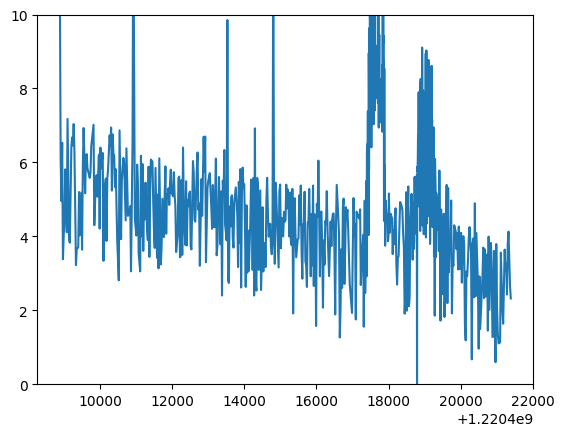

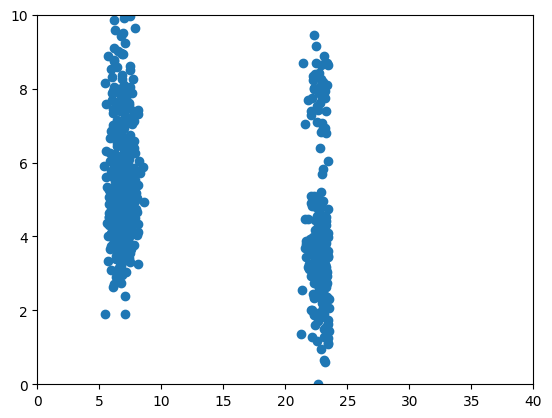

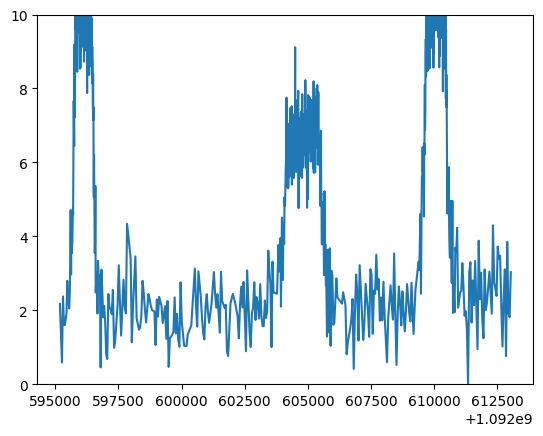

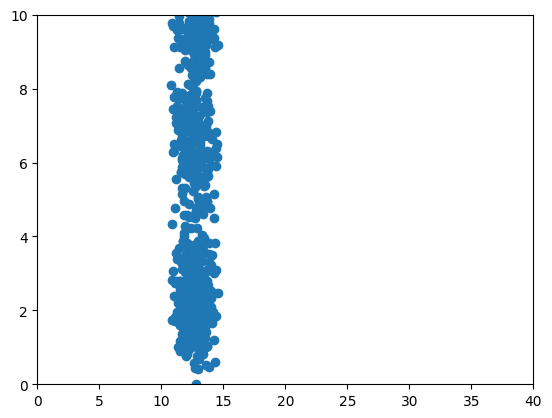

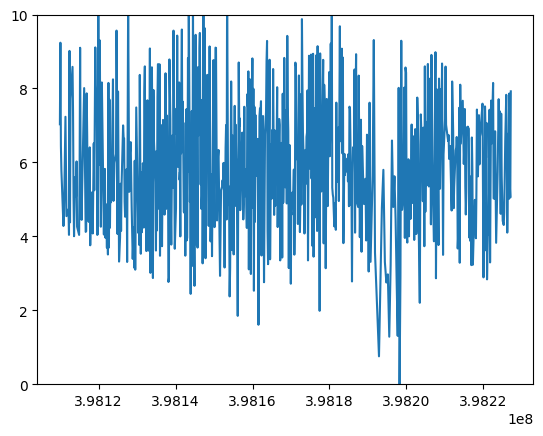

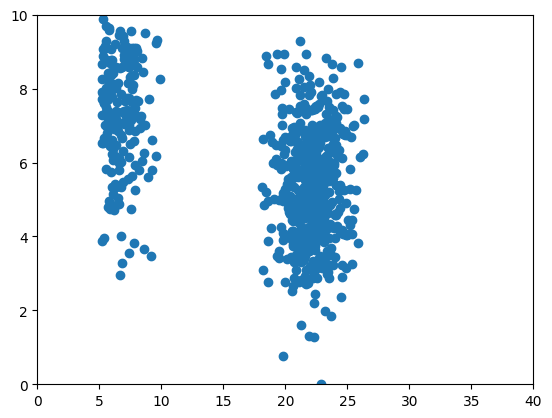

,wall_thickness,magnetization
0,12.055912,5.234029
1,12.650343,6.055082
2,18.084820,5.920694


'centers used: 3'

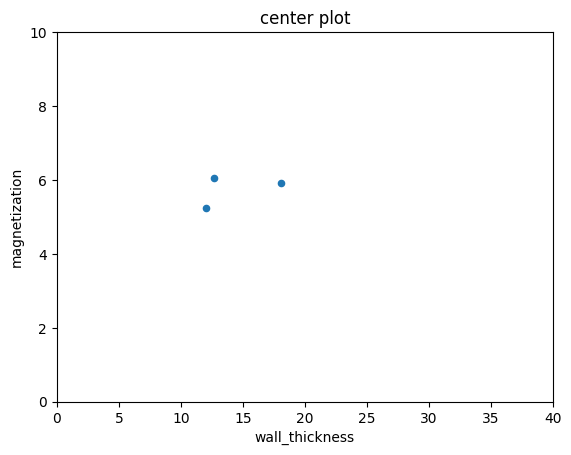

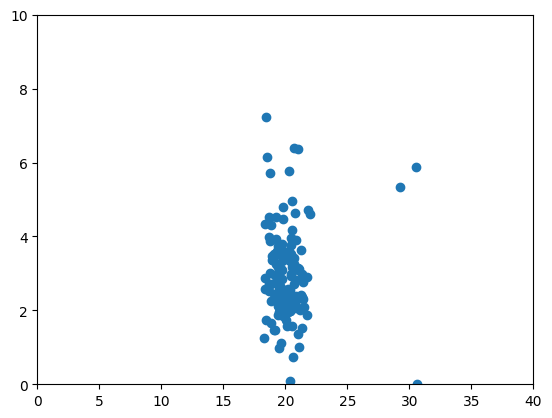

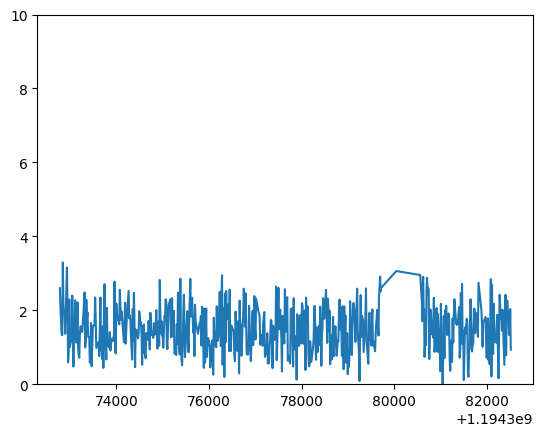

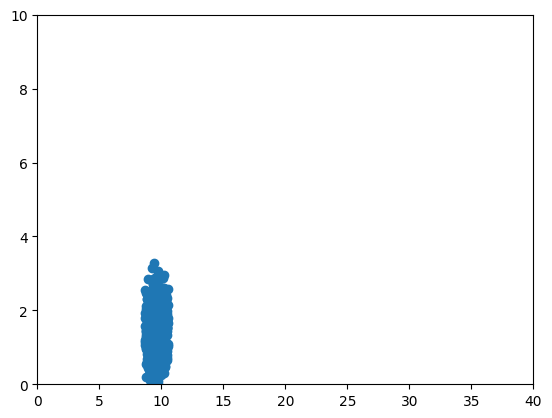

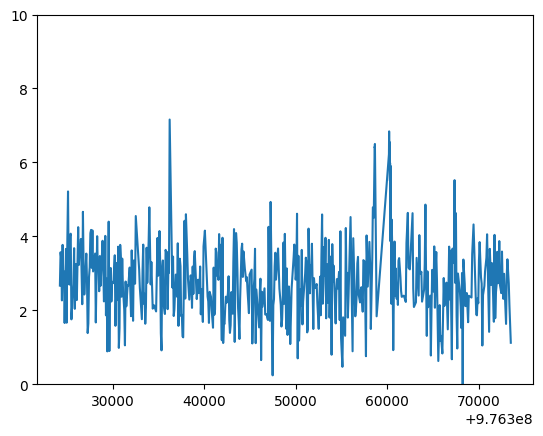

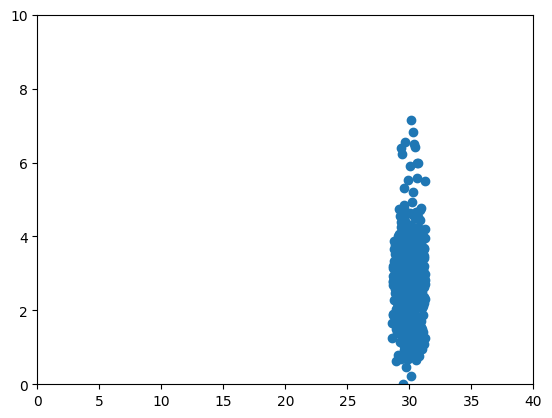

,wall_thickness,magnetization
0,27.281739,14.361362
1,9.617182,1.482779
2,29.945981,2.811888


'centers used: 3'

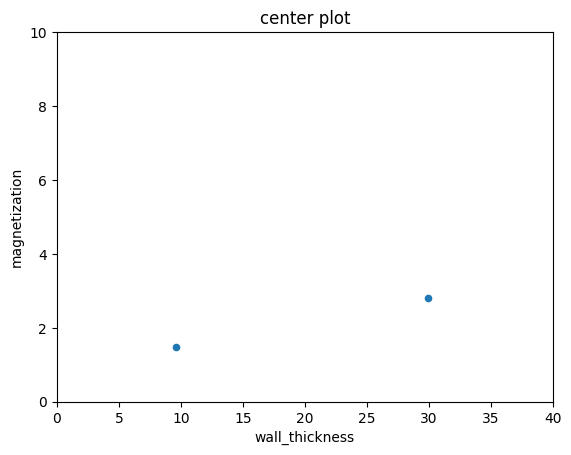

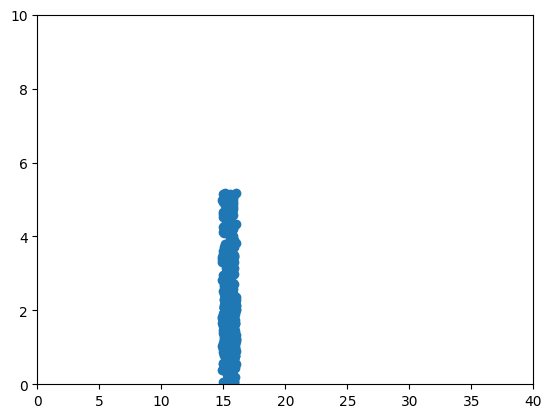

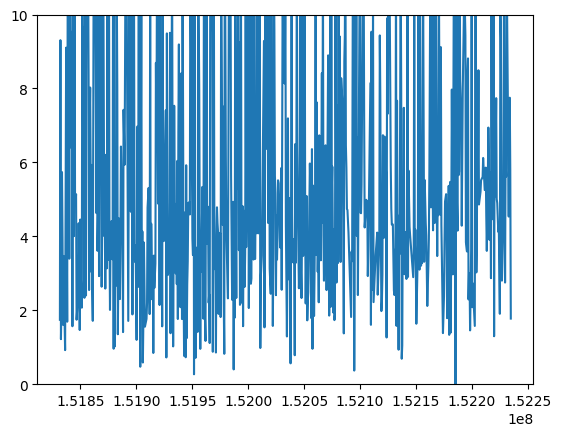

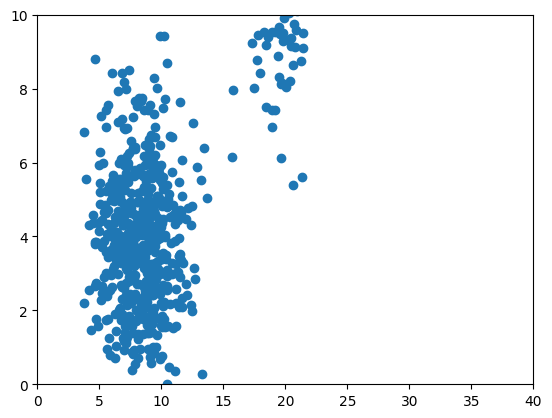

,wall_thickness,magnetization
0,15.460654,2.207782
1,10.897393,5.537043


'centers used: 2'

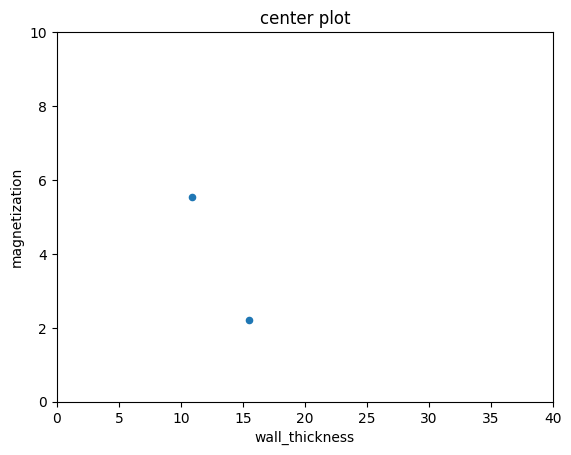

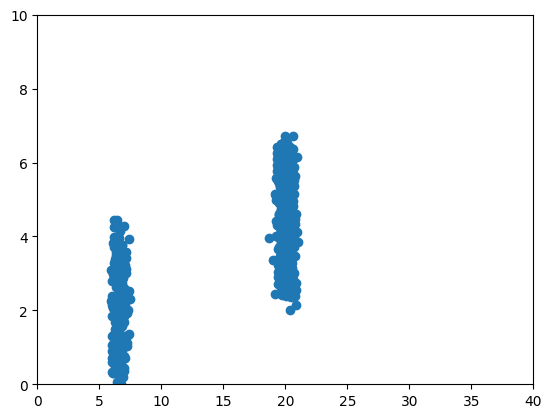

,wall_thickness,magnetization
0,16.171092,3.913859


'centers used: 1'

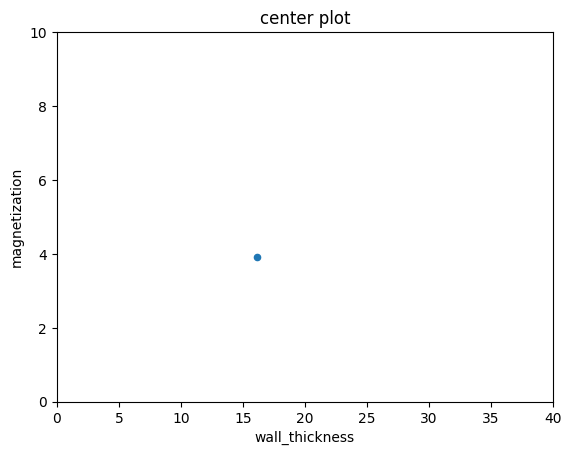

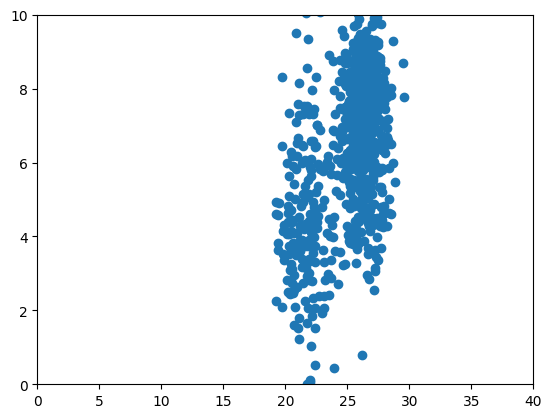

,wall_thickness,magnetization
0,25.149795,6.475196


'centers used: 1'

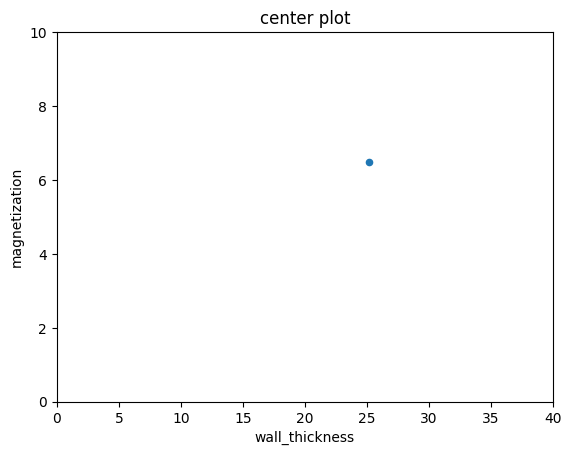

In [888]:
dfs = {}

# filter only by instrument, configuration currently not distinguished
for name in files["instrument"].unique():
    temp_df = files[files["instrument"] == name]

    temp_df = temp_df.apply(prepare_data, axis=1)
    
    array_wall_thickness = np.concatenate(temp_df["wall_thickness"].values)
    array_magnetization = np.concatenate(temp_df["magnetization"].values)
    array_centers = np.concatenate(temp_df["centers"].values)
    
    d = pd.DataFrame(array_centers)
    d.columns = ["wall_thickness", "magnetization"]
    display(d.head())
    
    display(f"centers used: {d["magnetization"].count()}")
    d.plot(kind="scatter", x="wall_thickness", y="magnetization", title="center plot", xlim=(0,40), ylim=(0, 10))
    
    
    new_df = pd.DataFrame({"wall_thickness": array_wall_thickness, "magnetization": array_magnetization})
    dfs[name] = new_df
    
    #display(temp_df.head())
    #temp
    #break


'Unicorn'

<Axes: xlabel='wall_thickness', ylabel='magnetization'>

'Pufferfish'

<Axes: xlabel='wall_thickness', ylabel='magnetization'>

'Dolphin'

<Axes: xlabel='wall_thickness', ylabel='magnetization'>

'Dog'

<Axes: xlabel='wall_thickness', ylabel='magnetization'>

'Elephant'

<Axes: xlabel='wall_thickness', ylabel='magnetization'>

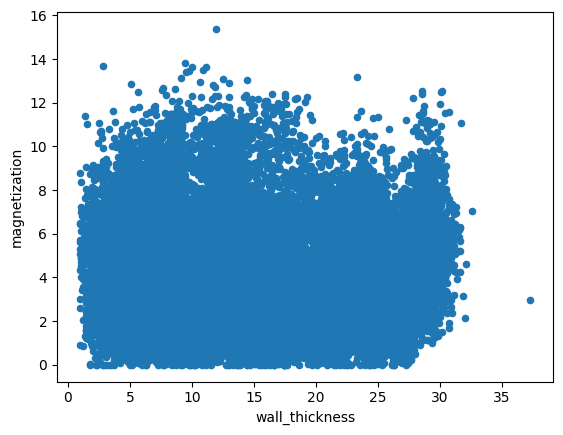

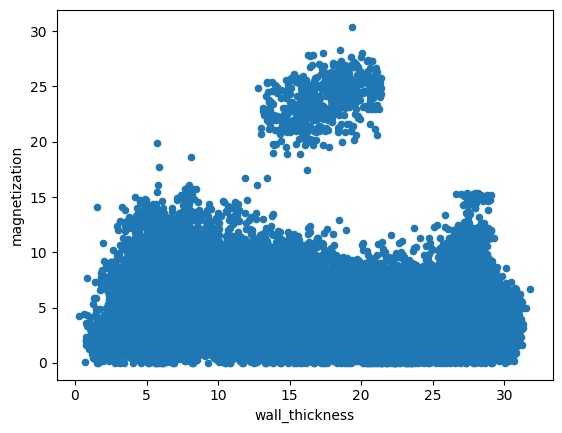

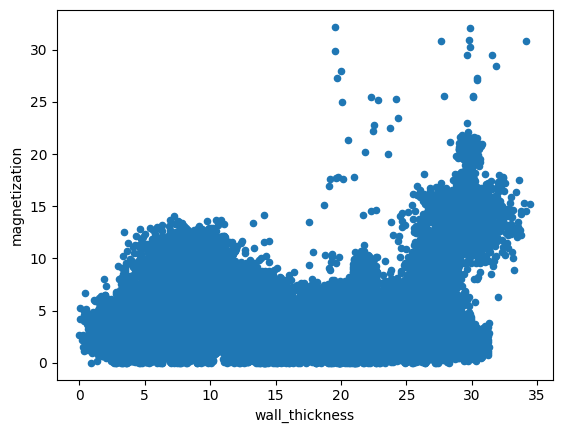

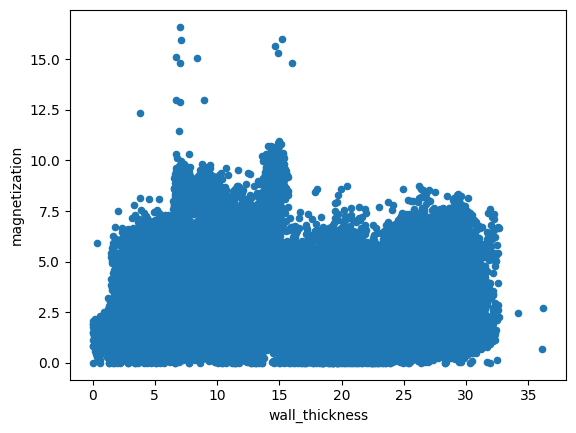

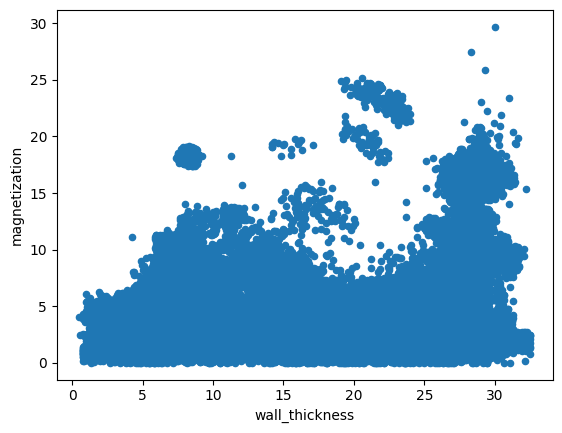

In [790]:
for instrument, df in dfs.items():
    display(instrument)
    display(df.plot(kind="scatter", x="wall_thickness", y="magnetization"))
    
    

hier ist wahrscheinlich irgendwo der effekt mit den "langgezogenen punktwolken" aufgrund der abnutzung der kontakte drin

In [7]:
files.head()

,_id,instrument,configuration,magnetization,wall_thickness
0,006b0b34-324b-496a-8ed7-a40f7d689ee9,Unicorn,Europe,"[0.27603825323679154, 97.86067498679706, 2.207...","[23.99222341036084, 24.10463223116243, 22.7322..."
1,0108e474-f1f4-4274-bf9f-e51d4963c091,Pufferfish,Europe,"[9.436639690926366, 7.864456069974779, 11.0914...","[21.653860163116526, 21.2720484396535, 26.1405..."
2,03da0eaa-98db-40d3-87bf-73ade130ac7c,Pufferfish,Europe,"[13.013569081675818, 11.457331570306037, 12.72...","[13.237698486111132, 4.135358086358272, 13.752..."
3,041849e0-d9ce-4ce1-b325-dcc5df055b80,Dolphin,Europe,"[-17.5514024471966, -16.797828223966338, -17.3...","[6.99012365895839, 6.6095069463976595, 7.07231..."
4,046eb9c7-f409-4125-a9c7-c237094ab837,Dog,Europe,"[-5.753318330394104, -4.892938582370071, -6.44...","[25.553738081262658, 13.500313367948351, 18.97..."
